# Road Lane Detection 

***

### Objective of the project

 The objective of this project is to develop a lane detection system that processes video footage to identify and highlight lane markings on roadways. The system provides real-time visual feedback to drivers by overlaying lane boundaries and issuing warnings when the vehicle deviates from its lane. This solution aims to enhance road safety and assist drivers in maintaining proper lane discipline, leveraging image processing techniques such as color space conversion, edge detection, and Hough transforms.

***

#### Steps Involved
1. Data Collection
2. Preprocessing
   - Color Space Conversion 
   - Grayscale Conversion 
3. Image Smoothing
   - Gaussian Smoothing 
4. Edge Detection
   - Canny Edge Detection 
5. Region of Interest Selection
   - Region Masking 
6. Lane Detection
   - Hough Transform 
7. Lane Line Drawing
   - Drawing Lane Lines 
8. Feedback Integration
   - Visual Feedback
   - Warning Display 
9. Video Processing
   - Video Reading and Writing
   - Real-Time Display
10. Output Saving
    - Save Processed Video 
11. Testing and Validation
    - Testing
    - Adjustments

***

##### 1. Import the neccessary libraries

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import math
import json
from IPython.display import Video, display 

%matplotlib inline

Loading the Test images and displaying it.

In [19]:
def list_images(images):
    num_images = len(images)
    
    # Set the number of columns
    cols = 3  # You can adjust this
    # Calculate the number of rows required
    rows = math.ceil(num_images / cols)
    
    # Create the figure and subplots without excessive white space
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    # Flatten the axes array for easy iteration if there are multiple rows
    axes = axes.flatten() if rows > 1 else [axes]
    
    # Iterate over images and display them in subplots
    for i, (ax, image) in enumerate(zip(axes, images)):
        ax.imshow(image)
        ax.axis('off')  # Remove the axis for a cleaner display

    # Hide any unused subplots (if fewer images than grid size)
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between subplots
    plt.show()

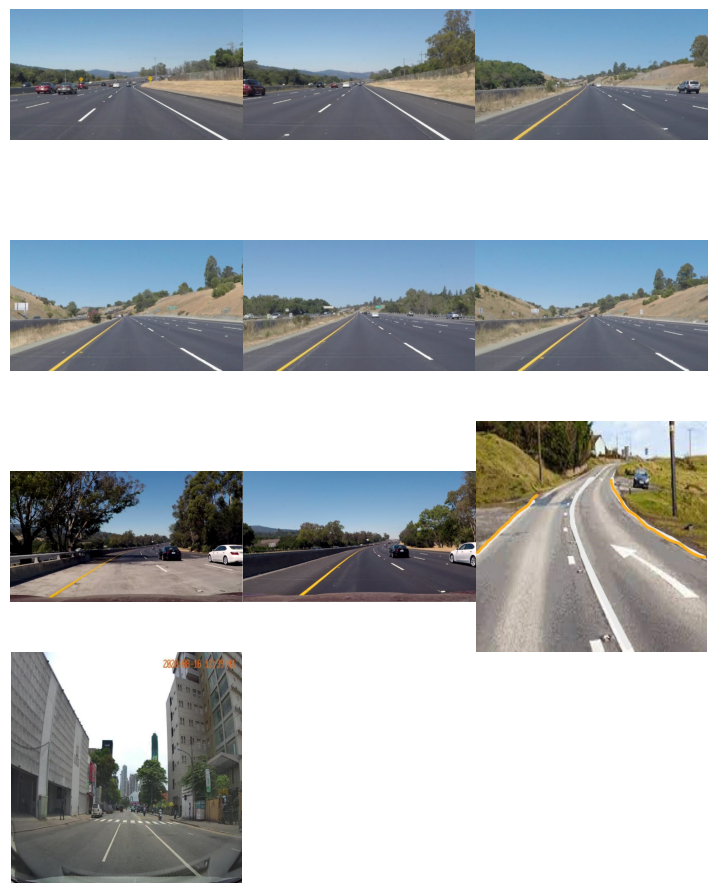

In [30]:
#Reading in the test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

##### 2. Preprocessing

1. Colour Space conversion:

In [31]:
def RGB_color_selection(image):
    
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

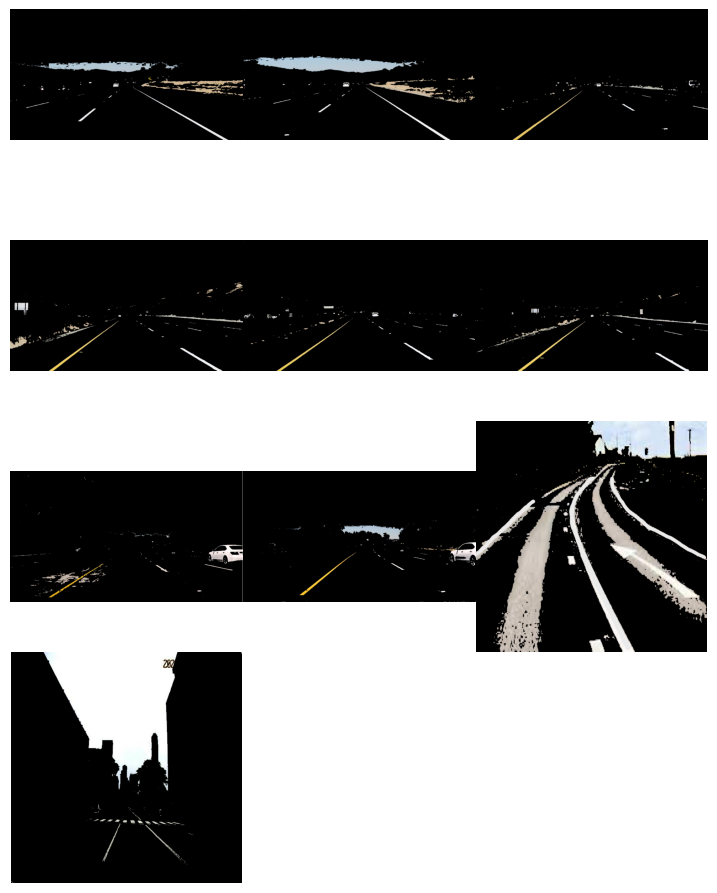

In [29]:
list_images(list(map(RGB_color_selection, test_images)))

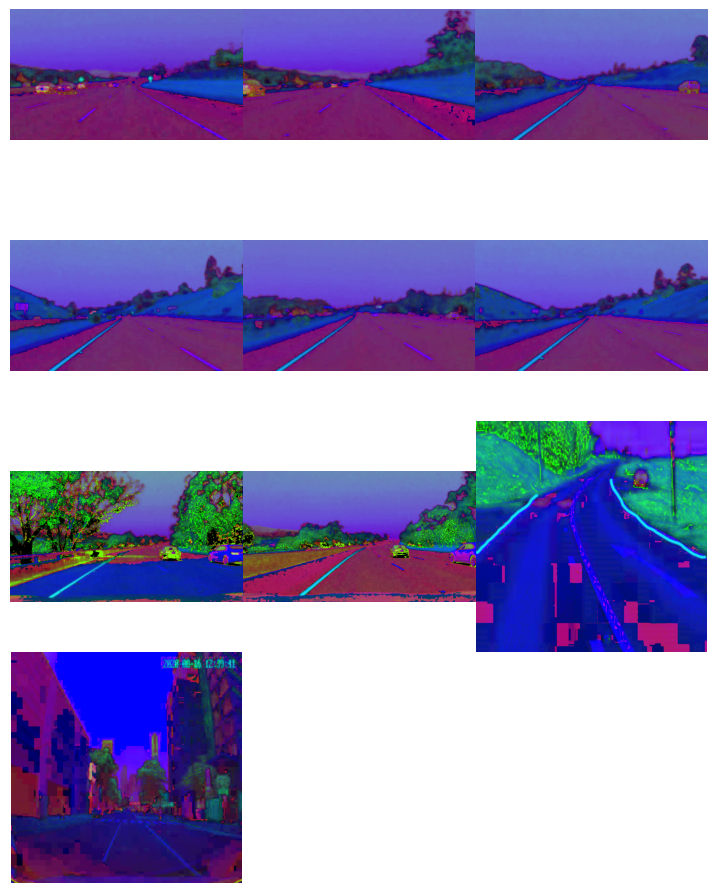

In [32]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [33]:
def HSV_color_selection(image):

    #Convert the input image to HSV
    converted_image = convert_hsv(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

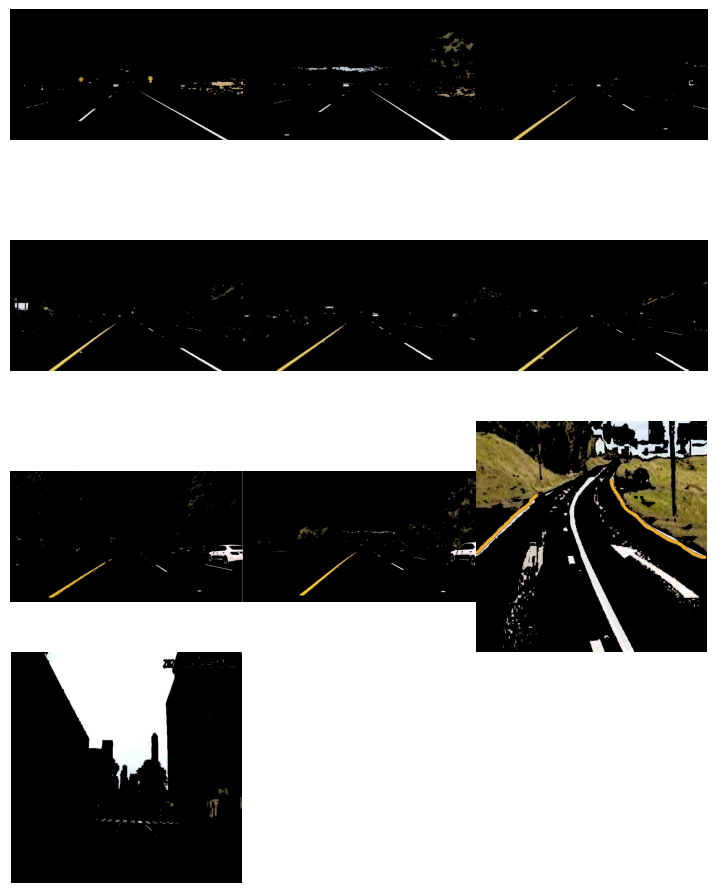

In [34]:
list_images(list(map(HSV_color_selection, test_images)))

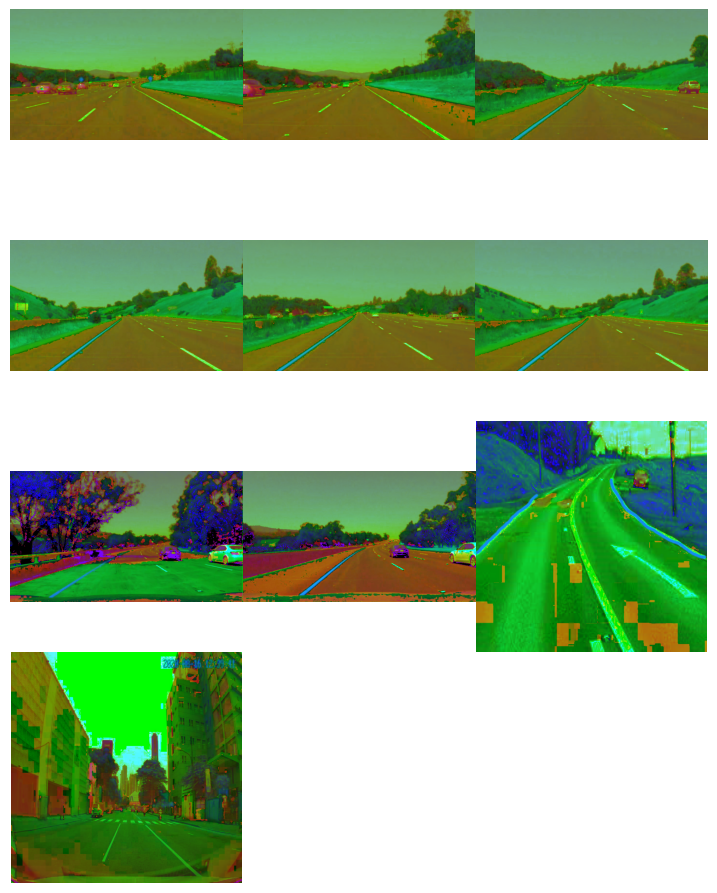

In [35]:
def convert_hsl(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [36]:
def HSL_color_selection(image):
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

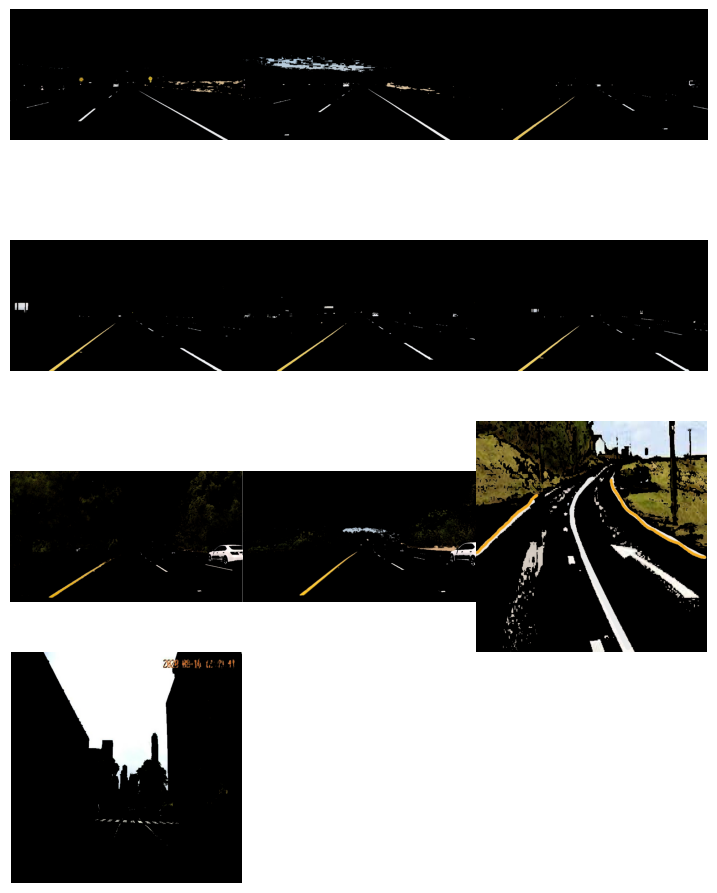

In [37]:
list_images(list(map(HSL_color_selection, test_images)))

In [38]:
color_selected_images = list(map(HSL_color_selection, test_images))

2. Grayscale Conversion 

In [39]:
def gray_scale(image):
   
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

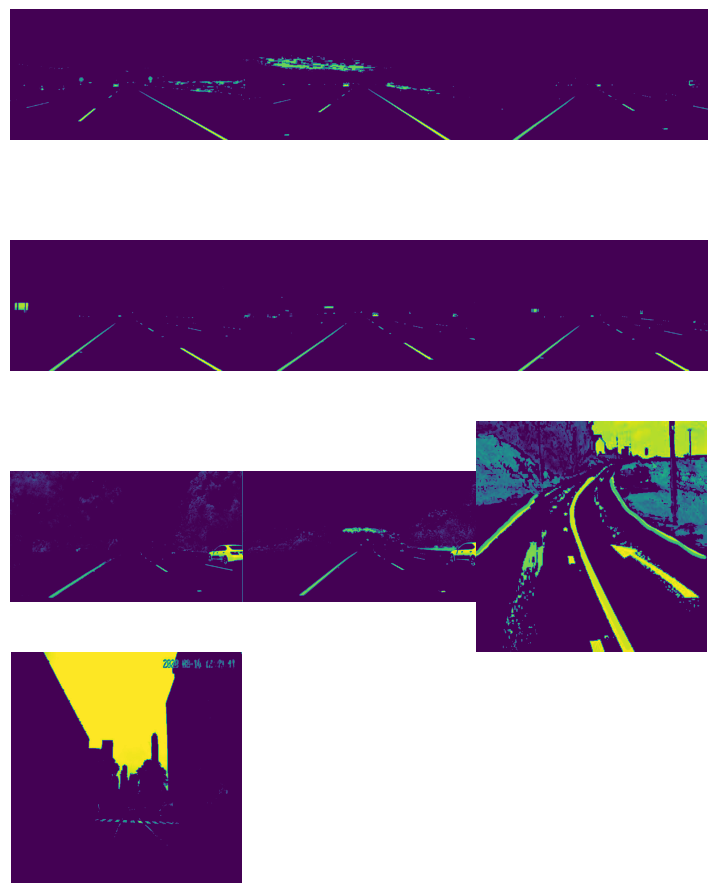

In [40]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

##### 3. Image Smoothing

1. Gaussian Smoothing:

In [41]:
def gaussian_smoothing(image, kernel_size = 13):

    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

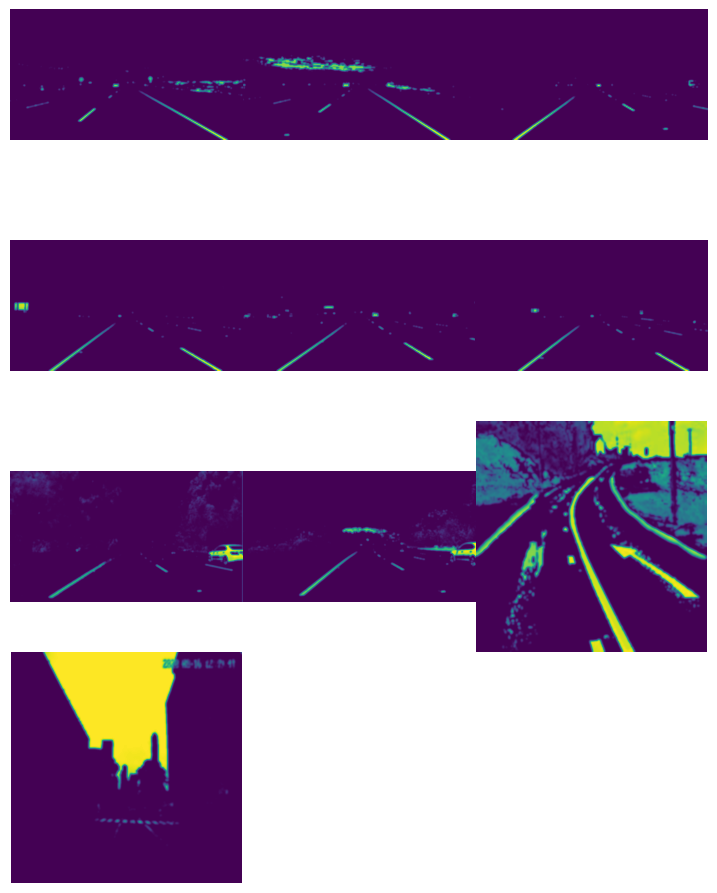

In [42]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

##### 4. Edge Detection

1. Canny Edge Detection

In [43]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):

    return cv2.Canny(image, low_threshold, high_threshold)

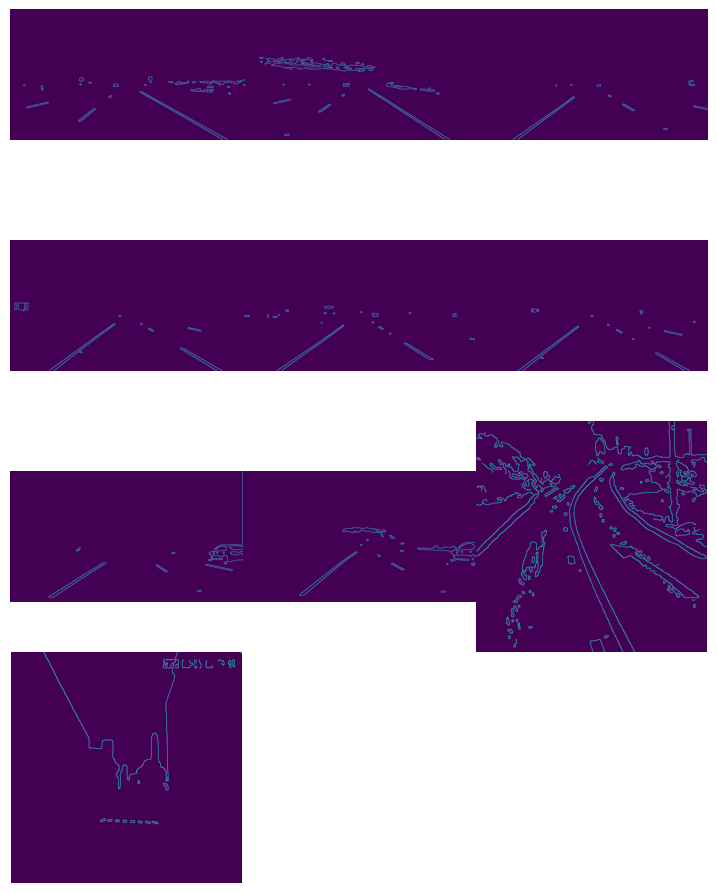

In [44]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

##### 5. Region of Interest Detection:

1. Region Masking

In [45]:
def region_selection(image):

    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

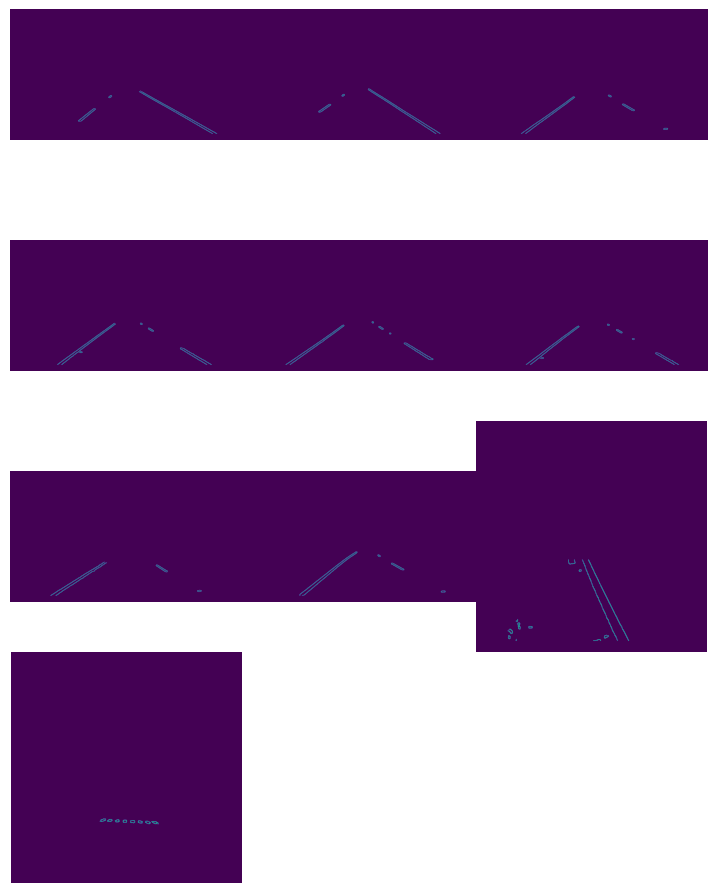

In [46]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

##### 6. Lane Detection

1. Hough Transform

In [47]:
def hough_transform(image):

    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 20       #Only lines that are greater than threshold will be returned.
    minLineLength = 20   #Line segments shorter than that are rejected.
    maxLineGap = 300     #Maximum allowed gap between points on the same line to link them
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [50]:
hough_lines = list(map(hough_transform, masked_image))

##### 7. Lane Line Drawing

In [48]:
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):

    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

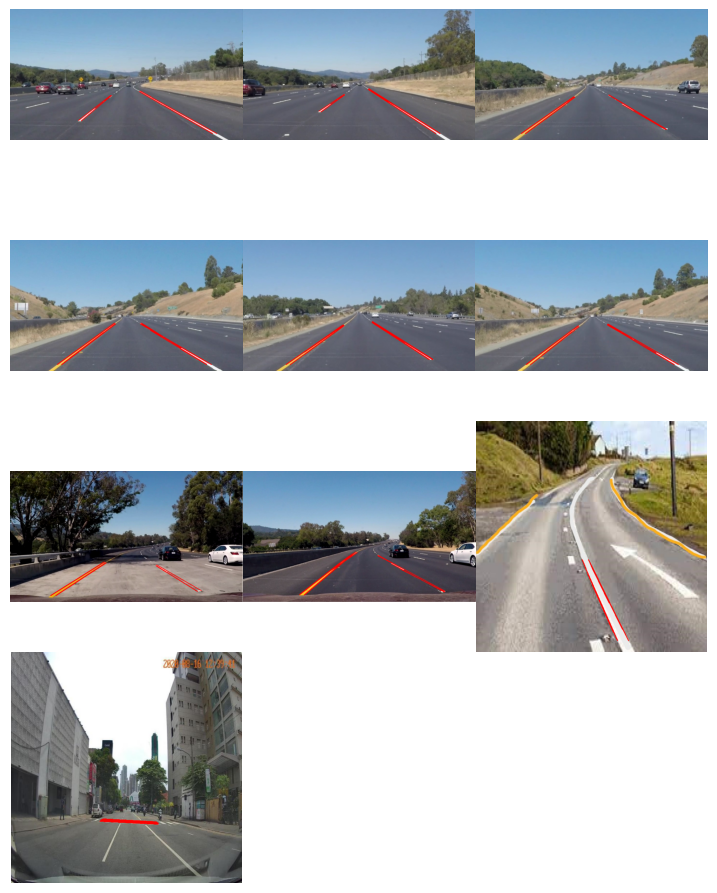

In [51]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [52]:
def average_slope_intercept(lines):

    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [53]:
def pixel_points(y1, y2, line):

    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

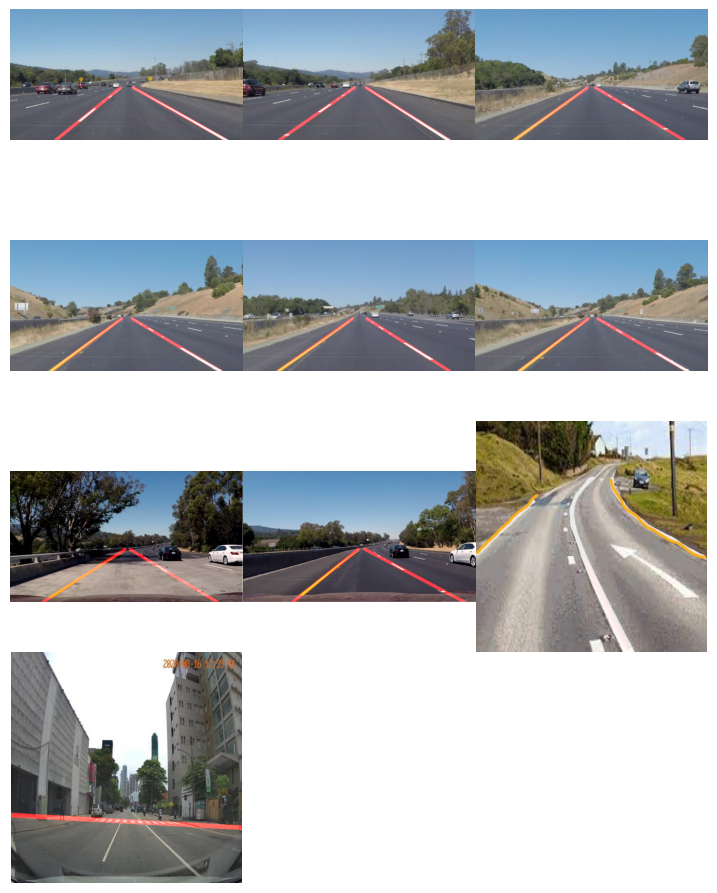

In [54]:
def lane_lines(image, lines):

    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):

    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
list_images(lane_images)

##### 8. Feedback Integration

In [80]:
import cv2
import numpy as np

def frame_processor(image):
    # Existing lane detection pipeline
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    region       = region_selection(edges)
    hough        = hough_transform(region)
    lane_lines_img = draw_lane_lines(image, lane_lines(image, hough))

    # Visual feedback: Draw lane boundaries
    height, width = image.shape[:2]
    left_boundary_x = int(width * 0.25)
    right_boundary_x = int(width * 0.75)
    lane_center_x = width // 2

    # Draw lane boundaries
    cv2.line(lane_lines_img, (left_boundary_x, height), (left_boundary_x, 0), (0, 255, 0), 2)  # Left boundary
    cv2.line(lane_lines_img, (right_boundary_x, height), (right_boundary_x, 0), (0, 255, 0), 2)  # Right boundary

    # Feedback for lane departure (if vehicle is outside the boundaries)
    if lane_center_x < left_boundary_x or lane_center_x > right_boundary_x:
        cv2.putText(lane_lines_img, 'Lane Departure Warning', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    return lane_lines_img


##### 9. Video Processing

In [81]:
import cv2
import os
import json

def process_video(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    output_path = os.path.join(output_folder, os.path.basename(video_path).replace('.mp4', '_lane_detection.mp4'))
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Video {video_path} not opened or invalid path.")
        return
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (1280, 720))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, (1280, 720))
        lane_image = frame_processor(frame)
        
        out.write(lane_image)
        
        # Display feedback video
        cv2.imshow("Lane Detection", lane_image)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processed video saved to {output_path}")

# Load configuration
with open('config.json') as f:
    config = json.load(f)

video_paths = config['video_paths']
output_folder = config['output_folder']

# Process each video
for video_path in video_paths:
    process_video(video_path, output_folder)


Processed video saved to C:/Users/harin/OneDrive/Desktop/Projects/Lane detection - lanenet/output video\challenge_lane_detection.mp4
Processed video saved to C:/Users/harin/OneDrive/Desktop/Projects/Lane detection - lanenet/output video\solidWhiteRight_lane_detection.mp4
Processed video saved to C:/Users/harin/OneDrive/Desktop/Projects/Lane detection - lanenet/output video\solidYellowLeft_lane_detection.mp4
